In [1]:
import pandas as pd
from tbdynamics.constants import (
    age_strata,
    organ_strata,
    compartments,

)
import nevergrad as ng
from estival.wrappers import nevergrad as eng
# Import our convenience wrapper
from estival.wrappers.nevergrad import optimize_model
from tbdynamics.calib_utils import get_bcm
from multiprocessing import cpu_count
from estival.sampling import tools as esamp
from estival.sampling.tools import SampleIterator, SampleTypes
from estival.utils.parallel import map_parallel
import pymc as pm
from estival.wrappers import pymc as epm
import arviz as az
import numpy as np

c:\Users\vbui0010\Anaconda3\envs\tbdyn\lib\site-packages\computegraph\jaxify.py:37: UserWarning: Could not import jax, model performance will be limited
  warnings.warn("Could not import jax, model performance will be limited")
WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Define Model

### Params and calibration targets

In [3]:
bcm = get_bcm()

### Running Optimization

In [4]:
def optimize_ng_with_idx(item):
    idx, sample = item
    opt = eng.optimize_model(bcm, budget=1000, opt_class=ng.optimizers.TwoPointsDE, suggested = sample, num_workers=4)
    rec= opt.minimize(1000)
    return idx, rec.value[1]

In [5]:
lhs_samples = bcm.sample.lhs(16)

In [6]:
lhs_lle = esamp.likelihood_extras_for_samples(lhs_samples, bcm)

In [ ]:
lhs_sorted = lhs_lle.sort_values("loglikelihood", ascending=False)

Index([8, 2, 10, 0, 1, 14, 15, 7, 4, 12, 13, 3, 6, 11, 9, 5], dtype='int64', name='sample')

In [ ]:
best8 = lhs_samples[lhs_sorted.index].iloc[0:8]

In [ ]:
opt_samples_idx = map_parallel(optimize_ng_with_idx, best8.iterrows())

In [ ]:
lle_samps = esamp.likelihood_extras_for_samples(opt_samples_idx, bcm)

,logposterior,logprior,loglikelihood,ll_notification,ll_percentage_latent,ll_prevalence_pulmonary,ll_total_population
sample,,,,,,,
8,-29685.914062,-9.344937,-29676.568359,-18918.617188,-110.438377,-3910.497803,-6737.015625
2,-62134.687500,-9.344937,-62125.343750,-49227.882812,-103.182976,-7725.656738,-5068.619629
10,-18782.570312,-9.344937,-18773.224609,-14953.312500,-65.920059,-2296.686279,-1457.306152
0,-230170.578125,-9.344937,-230161.234375,-162482.203125,-115.339256,-20118.359375,-47445.332031
1,-15035.384766,-9.344937,-15026.040039,-9613.593750,-95.351883,-3860.218262,-1456.875732
14,-80797.703125,-9.344937,-80788.359375,-53940.421875,-100.200562,-10192.925781,-16554.808594
15,-67071.820312,-9.344937,-67062.476562,-57043.183594,-57.267227,-8358.984375,-1603.046631
7,-41256.054688,-9.344937,-41246.710938,-25757.562500,-63.157364,-4894.540039,-10531.447266


In [ ]:
best_opt_samps = bcm.sample.convert(opt_samples_idx)
best_opt_samps

,start_population_size,contact_rate,rr_infection_latent,rr_infection_recovered,progression_multiplier,seed_time,seed_num,seed_duration,smear_positive_death_rate,smear_negative_death_rate,smear_positive_self_recovery,smear_negative_self_recovery,screening_scaleup_shape,screening_inflection_time,screening_end_asymp
8,2.357477e+06,0.009124,0.260939,0.423131,1.028814,1895.608685,78.564832,4.620068,0.419568,0.030777,0.207593,0.177938,0.092122,1993.284692,0.594080
2,2.099216e+06,0.008374,0.226037,0.300395,1.193288,1909.900680,64.694368,3.116482,0.416892,0.021531,0.192130,0.200755,0.094881,1996.123312,0.581481
10,2.464449e+06,0.006120,0.483786,0.319312,1.149776,1891.753755,88.286923,2.318475,0.429966,0.017724,0.270531,0.162232,0.092374,1994.969317,0.599044
0,2.627341e+06,0.006472,0.210580,0.423252,1.489178,1892.420669,88.977793,4.853723,0.363214,0.032994,0.195745,0.200051,0.097133,1998.039250,0.502430
1,2.103577e+06,0.008830,0.278618,0.214480,1.032167,1899.293502,32.414243,3.592526,0.365962,0.024323,0.235135,0.181381,0.096062,1996.062200,0.551396
14,2.056936e+06,0.006480,0.410333,0.466579,1.187370,1909.158668,27.145949,2.266647,0.389473,0.019758,0.261260,0.200730,0.088233,1994.136785,0.526973
15,2.030153e+06,0.004610,0.463661,0.285378,1.441907,1913.866979,92.388758,1.074964,0.421237,0.032588,0.202848,0.207090,0.090999,1999.152257,0.556006
7,2.104464e+06,0.005879,0.264440,0.309948,1.329179,1896.389029,71.765587,2.603438,0.343442,0.028193,0.207149,0.205201,0.098226,1994.398153,0.593546


In [ ]:
init_samps = best_opt_samps.iloc[0:8].convert("list_of_dicts")

In [ ]:
with pm.Model() as model:
    variables = epm.use_model(bcm)
    idata = pm.sample(step=[pm.DEMetropolisZ(variables)],draws=1000, chains=8, initvals=init_samps)

Multiprocess sampling (8 chains in 4 jobs)
DEMetropolisZ: [start_population_size, contact_rate, rr_infection_latent, rr_infection_recovered, progression_multiplier, seed_time, seed_num, seed_duration, smear_positive_death_rate, smear_negative_death_rate, smear_positive_self_recovery, smear_negative_self_recovery, screening_scaleup_shape, screening_inflection_time, screening_end_asymp]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 307 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
start_population_size,2046761.600,69929.972,2000010.208,2257306.424,24157.262,17714.313,8.0,10.0,5.07
contact_rate,0.007,0.001,0.006,0.009,0.000,0.000,8.0,13.0,5.04
rr_infection_latent,0.337,0.099,0.230,0.500,0.035,0.026,8.0,14.0,5.11
rr_infection_recovered,0.345,0.088,0.239,0.491,0.031,0.023,8.0,10.0,5.34
progression_multiplier,1.032,0.030,1.001,1.092,0.011,0.008,8.0,10.0,5.24
seed_time,1891.939,2.579,1890.001,1897.026,0.904,0.663,9.0,13.0,3.87
seed_num,62.891,31.702,1.168,95.282,11.137,8.177,8.0,10.0,5.61
seed_duration,2.846,1.545,1.022,4.935,0.544,0.399,8.0,15.0,4.89
smear_positive_death_rate,0.405,0.034,0.337,0.449,0.012,0.009,8.0,11.0,5.18
smear_negative_death_rate,0.026,0.006,0.018,0.033,0.002,0.002,9.0,14.0,4.16


<AxesSubplot: xlabel='draw'>

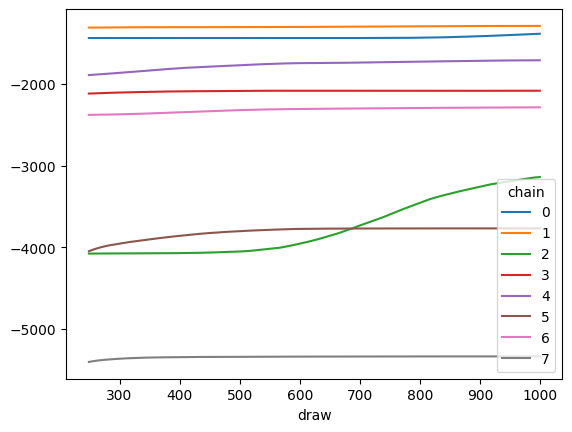

In [ ]:
lle = esamp.likelihood_extras_for_idata(idata, bcm)
lle["logposterior"].unstack(["chain"]).rolling(250).mean().plot()

In [ ]:
burnt_idata = idata.sel(draw=np.s_[200:])
sds = az.extract(burnt_idata, num_samples=500)

In [ ]:
samp_res = esamp.model_results_for_samples(sds,bcm)

In [ ]:
quantiles = esamp.quantiles_for_results(samp_res.results, (0.05,0.25,0.5,0.75,0.95))

<AxesSubplot: xlabel='time'>

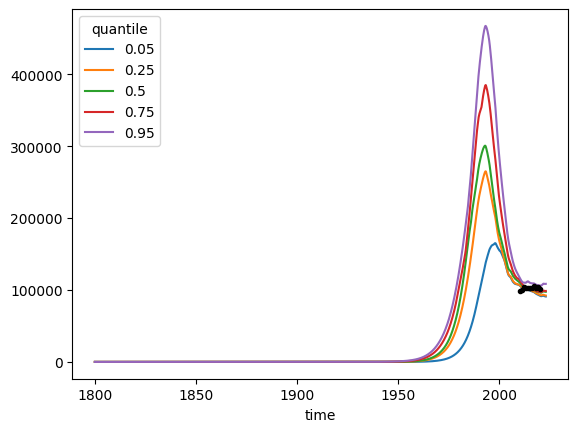

In [ ]:
quantiles["notification"].plot()
bcm.targets["notification"].data.plot(style='.',color="black")

In [ ]:
quantiles["total_population"].plot()
bcm.targets["total_population"].data.plot(style='.',color="black")